# FUZZY C MEANS

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
import calendar

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [2]:
# Cargar perfil fraudulento
badguy = pd.read_excel('Data/fraudster_SAG01XXX64.xlsx')
badguy['date'] = pd.to_datetime(badguy['date'])

# Explorar dataframe
badguy.head()

,date,power_real,power_fraud
0,2020-09-15 00:00:00,0.420,0.420
1,2020-09-15 01:00:00,0.221,0.221
2,2020-09-15 02:00:00,0.144,0.144
3,2020-09-15 03:00:00,0.140,0.140
4,2020-09-15 04:00:00,0.394,0.394


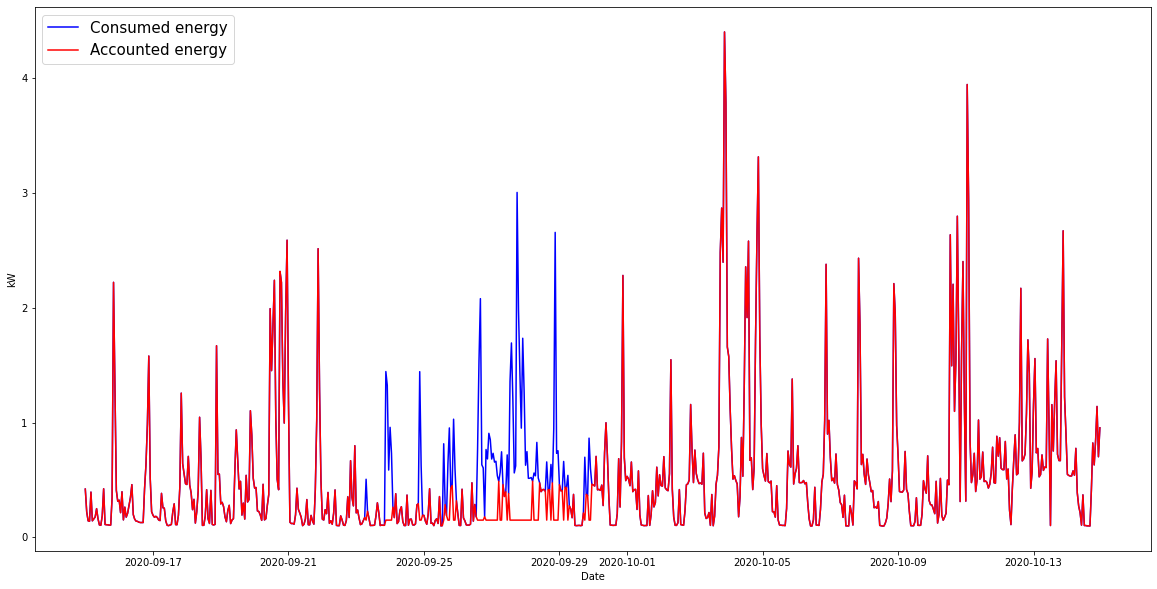

In [6]:
# Plot Real Profile vs. Fraudulent Profile
plt.figure(figsize=(20,10))
plt.plot(badguy['date'], badguy['power_real'], 'b', label='Consumed energy')
plt.plot(badguy['date'], badguy['power_fraud'], 'r', label='Accounted energy')
plt.xlabel('Date')
plt.ylabel('kW')
plt.legend(loc="upper left", prop={'size': 15})
plt.show()

In [7]:
# Crear df nuevo sin "power_real" y con features "day" y "time" derivados de la columna "datetime"
df_bg=badguy.copy()

df_bg['day'] = df_bg['date'].apply(lambda x:x.strftime('%Y%m%d'))
df_bg['time'] = df_bg['date'].apply(lambda x:x.strftime('%H:%M'))
df_bg = df_bg.drop(['date', 'power_real'], axis=1)

df_bg.head()

,power_fraud,day,time
0,0.420,20200915,00:00
1,0.221,20200915,01:00
2,0.144,20200915,02:00
3,0.140,20200915,03:00
4,0.394,20200915,04:00


# Fuzzy C-Means

In [8]:
# https://github.com/omadson/fuzzy-c-means/blob/master/fcmeans/fcm.py

In [9]:
# instalar liberia fuzzy-c-means
pip install fuzzy-c-means

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\marcjene\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [10]:
%matplotlib inline
import numpy as np
from fcmeans import FCM
from matplotlib import pyplot as plt

In [11]:
# crear copia del dataframe
df_cluster = df_bg.copy()

In [12]:
# analizar qué días contiene nuestro dataframe
list_days=df_bg['day'].unique()
n=df_bg['day'].nunique()
print('Number of days:', n)
list_days

Number of days: 30


array(['20200915', '20200916', '20200917', '20200918', '20200919',
       '20200920', '20200921', '20200922', '20200923', '20200924',
       '20200925', '20200926', '20200927', '20200928', '20200929',
       '20200930', '20201001', '20201002', '20201003', '20201004',
       '20201005', '20201006', '20201007', '20201008', '20201009',
       '20201010', '20201011', '20201012', '20201013', '20201014'],
      dtype=object)

In [13]:
# Definimos función "find_peaks" para crear feature

def find_peaks(day, nb_samples):
    daily_max_function = []
    
    for i in range(1,23):    # Look at the second day and the second last one so I can compare i-1, i, i+1
        if i==1 and day[i]>day[i+1]:
            daily_max_function.append(day[i])
        else:
            if i==23 and day[i+1]>day[i]:
                daily_max_function.append(day[i+1])
            if day[i]>day[i-1] and day[i]>day[i+1]:
                daily_max_function.append(day[i])
            
    daily_max_function.sort(reverse = True)
    final_average = sum(daily_max_function[0:nb_samples])/nb_samples
    return(final_average)

In [14]:
# Definimos función "cuts" para crear feature

def cuts(df,mean):
    power = df.iloc[0]['power_fraud']
    above = True
    above_0 = (power>mean)
    prev_above = above_0
    cuts = 0
    i=0
    for index, row in df.iterrows():
        if i!=0:
            power = row['power_fraud']
            above = power>mean
            if above!=prev_above:
                cuts += 1
                above = (power>mean)
            prev_above=above
            i+=1
        else:
            i+=1
    if above_0!=above:
        cuts += 1    
    return (cuts)

In [15]:
# Definimos función "deep_slopes" para crear feature

def deep_slopes(df, mean):
    power = df.iloc[0]['power_fraud']
    previous_p = power
    inc = 0
    dec = 0
    power_0 = power
    for index, row in df.iterrows():
        # print(power, inc, dec)
        power = row['power_fraud']
        if power>(previous_p+0.5*mean):
            inc += 1
        elif power<(previous_p-0.5*mean):
            dec += 1
        previous_p = power
    if power_0>(previous_p+0.5*mean):
        inc += 1
    elif power_0>(previous_p-0.5*mean):
        dec += 1
    return (inc,dec)

In [16]:
# Creamos dataframe vacío con los features que nos interesan
df = pd.DataFrame(columns=['date','mean','median','std','max', 'min', 'mean_p1','mean_p2',
                           'mean_p3','n_cuts','inc','dec','peaks_avg'])

# Creamos columna 'datetime' partiendo de la columna 'time' para poder aplicar
# funciones de la libreria dt
df_cluster['datetime'] =  pd.to_datetime(df_cluster['time'], format='%H:%M')

# Por cada dia en el dataframe calculamos los nuevos features
for day in list_days:
    
    # creamos dataframe con los datos de un solo dia
    daily_ref = df_cluster[df_cluster['day'] == day]
    
    # media
    mean = daily_ref['power_fraud'].mean()
    
    # mediana
    median = daily_ref['power_fraud'].median()
    
    # desviación estándar
    std = daily_ref['power_fraud'].std()
    
    # máximo
    maxim = daily_ref['power_fraud'].max()
    
    # mínimo
    minim = daily_ref['power_fraud'].min()
    
    # media entre 0h y 8h
    daily_p1 = daily_ref[daily_ref['datetime'].dt.hour < 8]
    mean_p1 = daily_p1['power_fraud'].mean()
    
    # media entre 8h y 16h
    daily_p2 = daily_ref[(daily_ref['datetime'].dt.hour > 8) & (daily_ref['datetime'].dt.hour < 16)]
    mean_p2 = daily_p2['power_fraud'].mean()
    
    # media entre 16h y 24h
    daily_p3 = daily_ref[(daily_ref['datetime'].dt.hour > 16) & (daily_ref['datetime'].dt.hour < 24)]
    mean_p3 = daily_p3['power_fraud'].mean()
    
    # número de cortes con la media
    n_cuts = cuts(daily_ref,mean)
    
    # número de incrementos y decrementos pronunciados en el consumo
    inc, dec = deep_slopes(daily_ref,mean)
    
    # consumo medio de los 2 picos del dia
    peak = find_peaks(list(daily_ref['power_fraud']), 2)
    
    # asignamos cada variable a su columna
    df = df.append({'date':day,'mean':mean,'std':std, 'median':median, 'max': maxim, 'min': minim, 'mean_p1':mean_p1, 
                    'mean_p2':mean_p2, 'mean_p3':mean_p3, 'n_cuts':n_cuts, 'inc':inc, 'dec':dec, 'peaks_avg':peak},
                   ignore_index=True)
    
df_features=df

# extraemos columna con las fechas, conservando el orden
df_date = df_features.iloc[:, 0]

# eliminamos columna 'date' ya que no es un feature
df_features.drop(['date'], axis = 1, inplace = True)

df_features.head()

,mean,median,std,max,min,mean_p1,mean_p2,mean_p3,n_cuts,inc,dec,peaks_avg
0,0.341000,0.1700,0.472341,2.221,0.105,0.225125,0.172571,0.688000,8,4,6,1.3220
1,0.347542,0.2190,0.331065,1.579,0.129,0.252250,0.193714,0.641429,6,5,5,1.0190
2,0.282125,0.1875,0.256461,1.256,0.102,0.207625,0.154714,0.523143,6,3,2,0.8195
3,0.402792,0.3595,0.361081,1.669,0.104,0.365875,0.386429,0.501429,8,5,8,1.3575
4,0.398833,0.3015,0.271623,1.103,0.120,0.226125,0.495571,0.549286,6,4,6,1.0195


In [17]:
# Escalamos los datos
from sklearn.preprocessing import StandardScaler

# Crear instancia para el Standard Scaler 
scaler = StandardScaler()

# Ajustar el scaler con df_features
scaler.fit(df_features)

# Transformar el df_features a uno escalado 
df_features_scaled = pd.DataFrame(scaler.transform(df_features), index=df_features.index, columns=df_features.columns)

df_features_scaled.head()

,mean,median,std,max,min,mean_p1,mean_p2,mean_p3,n_cuts,inc,dec,peaks_avg
0,-0.515531,-1.005398,0.234546,0.482702,-0.333892,-0.773762,-0.561501,-0.107180,0.503155,-0.081923,1.071217,0.000276
1,-0.492845,-0.743097,-0.260311,-0.106116,0.246790,-0.660073,-0.504051,-0.191361,-0.251577,0.737309,0.372597,-0.357621
2,-0.719699,-0.911719,-0.521635,-0.402359,-0.406478,-0.847109,-0.610024,-0.405170,-0.251577,-0.901155,-1.723262,-0.593265
3,-0.301248,0.009011,-0.155173,-0.023571,-0.358087,-0.183840,0.019603,-0.444420,0.503155,0.737309,2.468456,0.042207
4,-0.314975,-0.301468,-0.468526,-0.542685,0.029034,-0.769570,0.316172,-0.357915,-0.251577,-0.081923,1.071217,-0.357030


In [18]:
# La libreria fuzzy c-means trabaja con arrays en vez de dataframes, transformamos el df a array
new_df = df_features_scaled.to_numpy()
new_df

array([[-5.15530721e-01, -1.00539810e+00,  2.34546298e-01,
         4.82702182e-01, -3.33892249e-01, -7.73761652e-01,
        -5.61501378e-01, -1.07180062e-01,  5.03154605e-01,
        -8.19231921e-02,  1.07121680e+00,  2.75607753e-04],
       [-4.92845366e-01, -7.43097062e-01, -2.60311301e-01,
        -1.06115604e-01,  2.46789923e-01, -6.60073333e-01,
        -5.04050839e-01, -1.91360998e-01, -2.51577303e-01,
         7.37308728e-01,  3.72597146e-01, -3.57620746e-01],
       [-7.19698920e-01, -9.11719160e-01, -5.21635208e-01,
        -4.02358821e-01, -4.06477521e-01, -8.47108955e-01,
        -6.10023792e-01, -4.05170245e-01, -2.51577303e-01,
        -9.01155113e-01, -1.72326180e+00, -5.93265376e-01],
       [-3.01248033e-01,  9.01102213e-03, -1.55172678e-01,
        -2.35710547e-02, -3.58087340e-01, -1.83839775e-01,
         1.96030554e-02, -4.44420252e-01,  5.03154605e-01,
         7.37308728e-01,  2.46845609e+00,  4.22073588e-02],
       [-3.14974841e-01, -3.01467760e-01, -4.6852581

In [20]:
# Creamos FCM y lo ajustamos al dataframe

fcm = FCM(n_clusters=2)
fcm.fit(new_df)

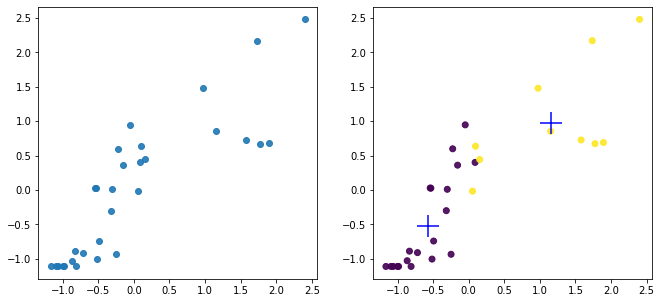

In [21]:
# Ploteamos los resultados

fcm_centers = fcm.centers
fcm_labels = fcm.predict(new_df)

f, axes = plt.subplots(1, 2, figsize=(11,5))
axes[0].scatter(new_df[:,0], new_df[:,1], alpha=.9)
axes[1].scatter(new_df[:,0], new_df[:,1], c=fcm_labels, alpha=.9)
axes[1].scatter(fcm_centers[:,0], fcm_centers[:,1], marker="+", s=500, c='b', label = 'group 1')

#plt.savefig('images/basic-clustering-output.jpg')
plt.show()

In [22]:
#Fuzzy partition array, returned as an array with n_samples rows and n_clusters columns
df_fcm = fcm.u
print (df_fcm)
type(df_fcm)
df_fcm.shape

[[0.83165963 0.16834037]
 [0.92808804 0.07191196]
 [0.81416951 0.18583049]
 [0.73712767 0.26287233]
 [0.88913529 0.11086471]
 [0.14249725 0.85750275]
 [0.66758318 0.33241682]
 [0.92437902 0.07562098]
 [0.86897654 0.13102346]
 [0.87663845 0.12336155]
 [0.88558695 0.11441305]
 [0.89076557 0.10923443]
 [0.88245893 0.11754107]
 [0.91875962 0.08124038]
 [0.92654538 0.07345462]
 [0.60691482 0.39308518]
 [0.8729509  0.1270491 ]
 [0.67557124 0.32442876]
 [0.2546798  0.7453202 ]
 [0.20153181 0.79846819]
 [0.75620131 0.24379869]
 [0.41139426 0.58860574]
 [0.39964603 0.60035397]
 [0.49241101 0.50758899]
 [0.91441946 0.08558054]
 [0.15407075 0.84592925]
 [0.33878751 0.66121249]
 [0.23849768 0.76150232]
 [0.21991179 0.78008821]
 [0.6119368  0.3880632 ]]


(30, 2)

In [32]:
# Probabilidad de pertenecer en el cluster 1 o 0
fuzzy_results = [] 
percentage = 0.15 # Parámetro a escoger para tunear el algoritmo
for c in range(0,30):
    if df_fcm[c][1]< percentage:
        fuzzy_results.append(1) 
    else:
        fuzzy_results.append(0)
        
fuzzy_r = np.array([fuzzy_results]).T
fuzzy_r_frame = pd.DataFrame(fuzzy_r)   
fuzzy_r_frame.columns=['cluster']
print(fuzzy_r_frame)

    cluster
0         0
1         1
2         0
3         0
4         1
5         0
6         0
7         1
8         1
9         1
10        1
11        1
12        1
13        1
14        1
15        0
16        1
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        1
25        0
26        0
27        0
28        0
29        0


In [33]:
# Añadimos fechas
df_new = pd.concat([df_date, fuzzy_r_frame], axis=1)
print (df_new)

        date  cluster
0   20200915        0
1   20200916        1
2   20200917        0
3   20200918        0
4   20200919        1
5   20200920        0
6   20200921        0
7   20200922        1
8   20200923        1
9   20200924        1
10  20200925        1
11  20200926        1
12  20200927        1
13  20200928        1
14  20200929        1
15  20200930        0
16  20201001        1
17  20201002        0
18  20201003        0
19  20201004        0
20  20201005        0
21  20201006        0
22  20201007        0
23  20201008        0
24  20201009        1
25  20201010        0
26  20201011        0
27  20201012        0
28  20201013        0
29  20201014        0


In [37]:
# Creamos vector grupo cluster real (0: no fraude, 1: fraude)
fraude = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Dataframe
df_new = df_new.rename(columns={"date":"day", "cluster": "label"})
df_new['real label'] = fraude
df_new

,day,label,real label
0,20200915,0,0
1,20200916,1,0
2,20200917,0,0
3,20200918,0,0
4,20200919,1,0
5,20200920,0,0
6,20200921,0,0
7,20200922,1,0
8,20200923,1,1
9,20200924,1,1


In [38]:
# Hacemos un merge para adjuntar las etiquetas al dataframe de los consumos horarios
df_labelled = pd.merge(df_bg, df_new, on='day')
df_labelled.head()

,power_fraud,day,time,label,real label
0,0.420,20200915,00:00,0,0
1,0.221,20200915,01:00,0,0
2,0.144,20200915,02:00,0,0
3,0.140,20200915,03:00,0,0
4,0.394,20200915,04:00,0,0


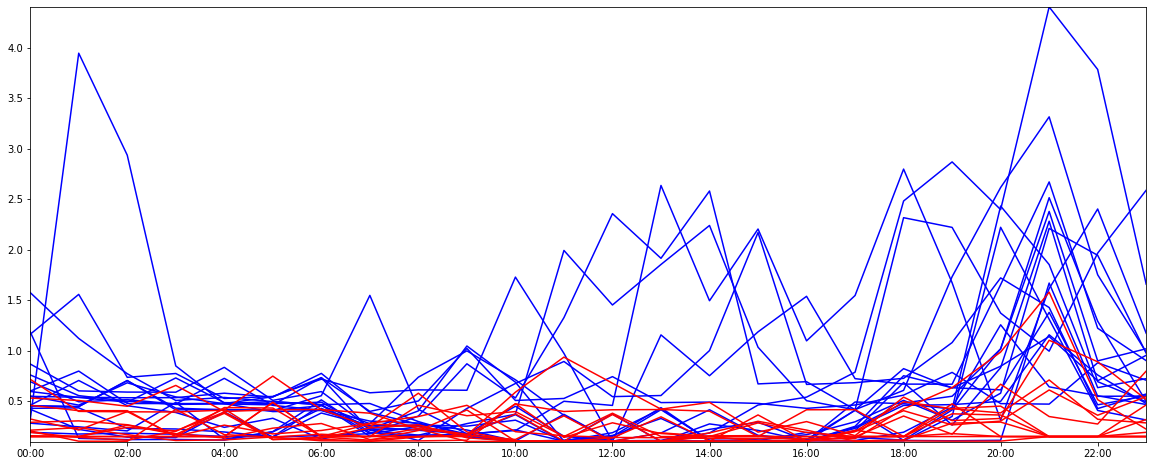

In [39]:
# Hacemos un plot de los perfiles de carga de cada dia pintándolos de un color distinto segun la etiqueta

list_labels = df_labelled['label'].unique()
plt.figure(figsize=(20,8))

for label in list_labels:
    df_label = df_labelled.loc[df_labelled['label']==label]
    list_dates = df_label['day'].unique()
    for date in list_dates:
        df_label_date = df_label.loc[df_label['day']==date]
        if label==0:
            plt.plot(df_label_date['time'],df_label_date['power_fraud'],'b')
        else:
            plt.plot(df_label_date['time'],df_label_date['power_fraud'],'r')

plt.xticks(np.arange(0, 48, step=2))
plt.margins(x=0, y=0)
plt.show()             